# Material Balances XIV

[What is Bond listening to right now?](https://www.youtube.com/watch?v=AmHjcpFAEkQ&list=RDAmHjcpFAEkQ&start_radio=1)

This lecture continues the discussion of reactor design for systems involving multiple reactions. Here, we formally define the concepts of yield and selectivity. These are complements to fractional conversion that quantify the relative quantities of various products formed. When there is more than one reaction occuring in a system, fractional conversion alone is an inadequate description of the process. We also need to understand yield and selectivity as they tell us about the extent to which each individual reaction occurs.

```{note}
We will stick with the example of Benzene Pyrolysis here because it is familiar from [Notebook 29](https://jqbond.github.io/CEN587/Notebooks/587-N29.html). We will simply apply a few new tools and concepts in the analysis.  These will help us to quantify product distributions in complex systems.
```

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

## Example Problem 01: Revisiting Benzene Pyrolysis in a PFR

```{note}
This is Example 4.5 from *Chemical Reactor Analysis and Design Fundamentals, 2nd ed.* by Rawlings and Ekerdt.
```

You are carrying out Benzene Pyrolysis in a Plug Flow Reactor operating at 1033K and 1.0 atm.  The two reactions occurring in this system are (1) benzene coupling to form diphenyl and hydrogen followed by (2) a secondary reaction between benzene and diphenyl to form triphenyl and hydrogen:

\begin{align*}
2B &\longleftrightarrow D + H_2\\
B + D &\longleftrightarrow T + H_2
\end{align*}

Both reactions are reversible and ***follow elementary rate laws***.  Rate constants and equilibrium concentration ratios ($K_C$) are given below.

\begin{align*}
k_1 &= 7.0 \ \times 10^5 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{h}^{-1}\\
k_2 &= 4.0 \ \times 10^5 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{h}^{-1}\\
K_{C_1} &= 0.31\\
K_{C_2} &= 0.48
\end{align*}

1. If pure benzene is fed into the reactor at 60,000 moles per hour, find the PFR volume required to achieve 50\% conversion of Benzene.
2. Plot the mole fraction of each species as a function of PFR volume.

**Answer**: $V = 403.3\mathrm{L}$

(solution-to-example-problem-01)=
### Solution to Example Problem 01

```{note}
This is exactly the same as the solution to [Example Problem 01 in Notebook 29](https://jqbond.github.io/CEN587/Notebooks/587-N29.html#example-problem-01). We will review the solution and then expand our analysis to include consideration of optimizing quantities of a desired product rather than achieving a specific conversion of benzene. This will motivate us to define metrics for quantifying yield and selectivity.
```

### Solution to Example Problem 01

Even though there are multiple reactions, we approach this problem the same way that we typically do: we have been asked to determine the reactor size required to achieve a certain conversion of Benzene. This prompts us to write a material balance on Benzene in a PFR operating at steady state:

$$\frac{dF_B}{dV} = R_B$$

$R_B$ is going to be a complex function of concentrations of all of the species present in this system. We say this because:

$$R_B = \sum_i \nu_{i,B} r_i$$

We can substitute stoichiometric coefficients for B in each reaction to find:

$$R_B = -2r_1 - r_2$$

We have two reactions, each with a unique rate expression:

\begin{align}
    r_1 &= k_{1,f}C_B^2 - k_{1,r}C_HC_D \\
    r_2 &= k_{2,f}C_BC_D - k_{2,r}C_HC_T \\
\end{align}

Examining these rate laws, we see that calculating $r_1$ and $r_2$ requires that we know concentrations for all species. That means we can't solve the above balance on Benzene until we have either (1) defined each concentration in terms of the same state variable or (2) write balances on each species to create a coupled system of ODEs wherein we have a unique state variable corresponding to each species. As before, when we have coupled systems of ODEs, we solve them all simultaneously using an ODE solver. We write a material balance on each species:

\begin{align}
    \frac{dF_B}{dV} &= R_B \\
    \frac{dF_D}{dV} &= R_D \\
    \frac{dF_H}{dV} &= R_H \\
    \frac{dF_T}{dV} &= R_T \\
\end{align}

We now have 4 ordinary differential equations that tell us how 4 state dependent variables ($F_B$, $F_D$, $F_H$, $F_T$) change as a function of the one independent variable, $V$. We can solve this system *if* we can define everything on the right hand sides of the above equations ($R_B$, $R_D$, $R_H$, and $R_T$) in terms of (1) constants, (2) our state variables ($F_B$, $F_D$, $F_H$, $F_T$), and/or (3) $V$.

We know how to do this!!

Generally:

$$R_j = \sum_i \nu_{i,j} r_i$$

So:

\begin{align}
    R_B &= -2r_1 - r_2 \\
    R_D &=  r_1 - r_2 \\
    R_H &=  r_1 + r_2 \\
    R_T &=  r_2 \\
\end{align}

We have already defined reaction rates:

\begin{align}
    r_1 &= k_{1,f}C_B^2 - k_{1,r}C_HC_D \\
    r_2 &= k_{2,f}C_BC_D - k_{2,r}C_HC_T \\
\end{align}

And we can define concentrations in terms of molar flowrates:

$$C_j = \frac{F_j}{Q}$$

This adds a volumetric flowrate, $Q$, into the mix. Fortunately, this is a gas phase reaction at low pressure, so we can define $Q$ in terms of the total molar flowrate:

$$Q = \frac{F_{tot}RT}{P}$$

Where

$$F_{tot} = \sum_j F_j$$

With that, we've defined our system of ODES fully as a function of molar flowrates and reactor volume. We can solve this numerically using `solve_ivp()`.  This is done in the code cell below.


The Volume required to achive 50% Benzene conversion is 411.9L


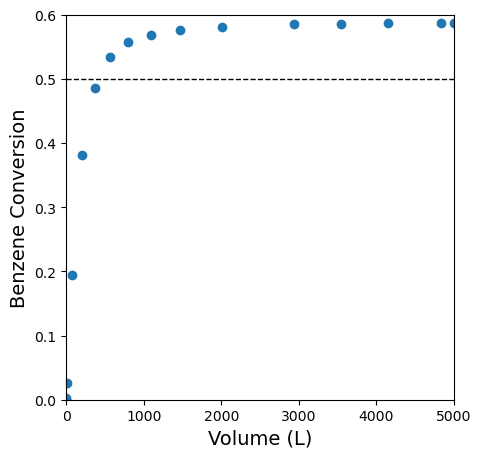

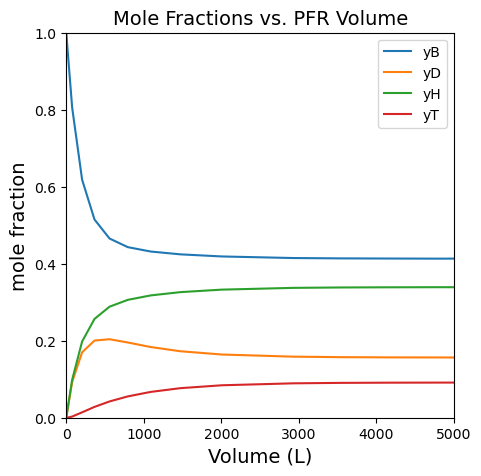

In [12]:
#############################################################
# Constants from problem statement; define as globals       #
#############################################################

T   = 1033    #K
P   = 1.0     #atm
R   = 0.08206 #L*atm/mol/K
k1f = 7.0e5   #L/mol/h
k2f = 4.0e5   #L/mol/h
KC1 = 0.31
KC2 = 0.48
k1r = k1f/KC1 #L/mol/h
k2r = k2f/KC2 #L/mol/h
FBf = 60000   #mol/h
FDf = 0
FHf = 0
FTf = 0

##############################################################
# Define ODE system in a function                            #
# Function has typical form f(V, [FB, FD, FH, FT])           #
# It returns [dFB/dV, dFD/dV, dFH/dV, dFT/dV]                #
##############################################################

def P01(vol, var):
    
    #unpack state-dependent variables in var
    FB, FD, FH, FT = var
    
    # The above is functionally equivalent to
    # FB = var[0]
    # FD = var[1]
    # FH = var[2]
    # FT = var[3]
      
    #total molar flowrate, function of individual molar flowrates
    FTOT = FB + FD + FH + FT
    
    #volumetric flowrate
    Q    = FTOT*R*T/P
    
    #Define concentrations
    CB   = FB/Q
    CD   = FD/Q
    CH   = FH/Q
    CT   = FT/Q
    
    #now that we have concentrations, we define reaction rates
    r1   = k1f*CB**2 - k1r*CD*CH
    r2   = k2f*CB*CD - k2r*CT*CH
    
    #With reaction rates, you can define production rates
    RB   = -2*r1 - r2
    RD   =    r1 - r2
    RH   =    r1 + r2
    RT   =         r2
    
    #For a PFR, dFj/dV = Rj, so these are our derivatives of FB, FD, FH, FT
    D1   = RB
    D2   = RD
    D3   = RH
    D4   = RT
    
    #return derivatives of each dependent variable w.r.t. volume
    return [D1, D2, D3, D4]

############################################################################
# Set starting state and integration span for solve_ivp()                  #
############################################################################
vspan   = (0, 5000)
var0    = [FBf, FDf, FHf, FTf]

############################################################################
# Solve using solve_ivp()                                                  #
############################################################################
solP01 = solve_ivp(P01, vspan, var0, atol = 1e-3, rtol = 1e-3)

############################################################################
# Extract necessary data from the solution structure.                      #
############################################################################
Vout    = solP01.t
FBout   = solP01.y[0]
FDout   = solP01.y[1]
FHout   = solP01.y[2]
FTout   = solP01.y[3]
FTot_o  = FBout + FDout + FHout + FTout

############################################################################
# Calculate fractional conversion of benzene                               #
############################################################################
XBout   = (FBf - FBout)/FBf

############################################################################
# Calculate species mole fractions                                         #
############################################################################
yBout   = FBout/FTot_o
yDout   = FDout/FTot_o
yHout   = FHout/FTot_o
yTout   = FTout/FTot_o

############################################################################
# Create an interpolating polynomial f(XB) = V; print f(0.5)               #
############################################################################
itp01   = interp1d(XBout, Vout, kind = 'cubic')
print(f'The Volume required to achive 50% Benzene conversion is {itp01(0.5):3.1f}L')

############################################################################
# Plot benzene conversion vs. reactor volume                               #
############################################################################
plt.figure(figsize = (5, 5))
plt.scatter(Vout, XBout)
plt.xlim(0, max(vspan))
plt.ylim(0, 0.6)
plt.hlines(0.5, 0, max(vspan), linestyle = 'dashed', color = 'black', linewidth = 1)
plt.xlabel('Volume (L)', fontsize = 14)
plt.ylabel('Benzene Conversion', fontsize = 14)
plt.show()

############################################################################
# Plot mole fractions vs. volume                                           #
############################################################################
plt.figure(figsize = (5, 5))
plt.title('Mole Fractions vs. PFR Volume', fontsize = 14)
plt.plot(Vout, yBout, label = 'yB')
plt.plot(Vout, yDout, label = 'yD')
plt.plot(Vout, yHout, label = 'yH')
plt.plot(Vout, yTout, label = 'yT')
plt.xlim(0, max(vspan))
plt.ylim(0, 1)
plt.xlabel('Volume (L)', fontsize = 14)
plt.ylabel('mole fraction', fontsize = 14)
plt.legend()
plt.show()

## Example Problem 02: Maximize the Production of Diphenyl

Thus far, we have determined that we would need a 403L PFR to achieve 50% conversion of Benzene. This is the type of question that we are used to answering at this point in the course, but fractional conversion is not always the most important metric in an industrial process. Further, as chemical engineers, we will likely be in the position of recommending ***the best*** way to operate a process instead of answering more straightforward questions about ***what size of reactor will achieve a specific fractional conversion***. Often, we are interested in forming a single product from a complex set of possible products, and our team is probably going to look to us to simply tell them what volume ***should the reactor be*** (instead of telling us what specifically needs to be accomplished in the reactor). The answer to "best" reactor design really depends on our goal. If, for example, process economics depend on maximizing Benzene conversion, then we would propose the design of a 3000L reactor because (1) this is the point where we reach maximum benzene conversion and (2) the reaction is equilibrium limited, so any reactor larger than 3000L does not lead to additional benzene conversion. In contrast, it may be that diphenyl is a valuable product, and we are interested in maximizing the quantity of diphenyl formed in the reactor. This is a fundamentally different goal, and we would make a different recommendation about this PFR. If we study the graphs above, we would probably conclude that maximizing the quantity of diphenyl is best achieved in 400L reactor. We make this decision after we consider that this is the point where the mole fraction of diphenyl is at a maximum. At volumes below this point, benzene conversion is too low to form sufficient diphenyl, and above this volume, the secondary reaction begins to consume diphenyl, reducing its quantity. Fundamentally, these are optimization problems, and we will use the concepts and methods covered in [Notebook 28](https://jqbond.github.io/CEN587/Notebooks/587-N28.html) to solve them.

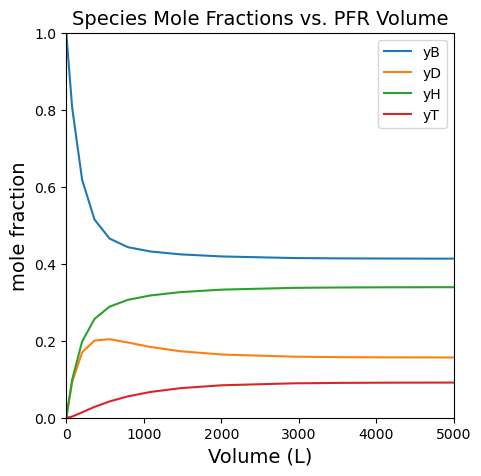

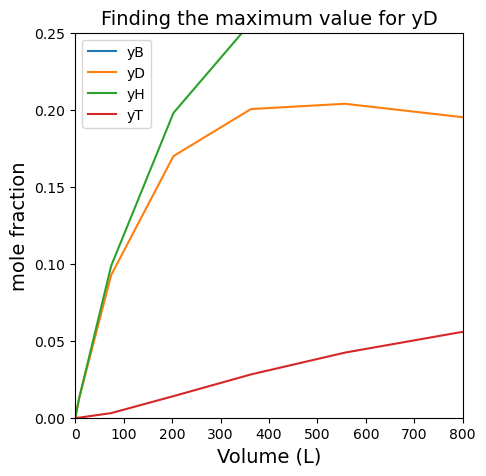

In [13]:
#Plot mole fractions vs. volume
plt.figure(2, figsize = (5, 5))
plt.title('Species Mole Fractions vs. PFR Volume', fontsize = 14)
plt.plot(Vout, yBout, label = 'yB')
plt.plot(Vout, yDout, label = 'yD')
plt.plot(Vout, yHout, label = 'yH')
plt.plot(Vout, yTout, label = 'yT')
plt.xlim(0, max(vspan))
plt.ylim(0, 1)
plt.xlabel('Volume (L)', fontsize = 14)
plt.ylabel('mole fraction', fontsize = 14)
plt.legend()
plt.show(2)

#Plot mole fractions vs. volume
plt.figure(3, figsize = (5, 5))
plt.title('Finding the maximum value for yD', fontsize = 14)
plt.plot(Vout, yBout, label = 'yB')
plt.plot(Vout, yDout, label = 'yD')
plt.plot(Vout, yHout, label = 'yH')
plt.plot(Vout, yTout, label = 'yT')
plt.xlim(0, 800)
plt.ylim(0, 0.25)
plt.xlabel('Volume (L)', fontsize = 14)
plt.ylabel('mole fraction', fontsize = 14)
plt.legend()
plt.show(3)

### Some crude optimization strategies

One thing we might do is consider that we have already calculated an array of diphenyl mole fractions at various reactor volumes.  We can use the Python function `max()` to find the largest value of diphenyl mole fraction. Alternatively, we can use `numpy.argmax()` to find the index of the largest diphenyl mole fraction. Both pieces of information are useful, and it is relatively straightforward to determine these values.

```{caution}
Keep mind that, in this example, we are using `max()` and `argmax()` to find the largest element in an array of diphenyl mole fractions, and that we calculated this array from an ODE solution generated using a step-based solver. These are discrete values, and they do not return the maximum value of diphenyl mole fraction as a function of volume, they only return the largest diphenyl mole fraction at the volume steps taken by our solver.  As we increase solver precision, these discrete maxima will approach the true maximum of the continuous function.
````


In [14]:
#########################################################################
# max() will find the largest element in an array                       #
#########################################################################

yDmax1 = max(yDout)
print(yDmax1)
print(f'The maximum diphenyl mole fraction is {yDmax1:0.3f}. \n')

#########################################################################
# np.argmax() will find the index of the largest element in an array    #
#########################################################################              

indexmax = np.argmax(yDout)
print(indexmax)
print(yDout[indexmax])
yDmax2   = yDout[indexmax]

##################################################################################################################################
# A nice bonus of knowing the index of the maximum is that we can use it to find the Volume that gives the maximum mole fraction #
##################################################################################################################################

Vmax2    = Vout[indexmax]
print(f'The maximum diphenyl mole fraction is {yDmax2:0.3f}, which we obtain at a PFR volume of {Vmax2:0.0f}L.')

0.20386485859594108
The maximum diphenyl mole fraction is 0.204. 

8
0.20386485859594108
The maximum diphenyl mole fraction is 0.204, which we obtain at a PFR volume of 557L.


### Introducing Yield and Selectivity

This question about optimizing the quantity of a single product from a set of possible products highlights the fact that conversion alone is not an adequate process specification when we are dealing with multiple reactions. We also need a way to quantify the amounts of each product that we make. In general, this is accomplished using ***Yield*** and ***Selectivity***.

```{caution}
Yield and Selectivity are commonly used terms in chemistry and chemical engineering; unfortunately, they do not have universal definitions, and you may find that they change depending on the textbook you are using or the team that you are working with. We will use what *I* consider to be the best definitions of Yield and Selectivity, but remember that not everyone uses these definitions. Because of this, anytime someone attempts to report a Yield or Selectivity to you, please ask for that person to define these terms to avoid misinterpretation.
```

#### Conceptual Definitions of Yield and Selectivity

We will define the ***yield*** of a specific product, $j$, as the percentage of a specific reactant that was converted into that specific product.  

We will define the ***overall selectivity*** of a product, $j$, as the percentage of consumed reactant that was converted into that specific product.

As usual, these concepts are best illustrated by application to a specific example

#### Consider a Pair of Generic Reactions

Let's discuss two reactions. The first one converts a reactant, $A$, into a desired product, $D$. By "desired," we mean a product that is valuable, non-toxic, and/or beneficial to society in some way. The second reaction occurs in parallel and converts our reactant $A$ into an undesired product, $U$. By "undesired", we mean a product that is toxic, costly to dispose of, or detrimental to society and/or process economics in some fashion. An example might be a toxic waste product or a greenhouse gas. 

\begin{align*}
    (1) \qquad \nu_{A1} \, A \longrightarrow \nu_{D1} D \\
    (2) \qquad \nu_{A2} \, A \longrightarrow \nu_{D1} U \\
\end{align*}

We would like to establish a general way for discussing the amounts of $D$ and $U$ that are produced in reaction. We will do so by developing specific definitions of Yield and Selectivity for both products that form in this system.

##### Yield

Yield is defined as the percentage of the reactant, $A$ in this case, that is converted into a specific product. 

**In a Batch Reactor...**

For a batch reactor, the total molar quantity of species is our typical state variable (i.e., it is the one that appears naturally in the batch reactor material balance, $dN_j/dt$). Accordingly, we use total molar quantities of species to define the yield of a species. Here, we would define the "yield of $D$ with respect to $A$" conceptually as: the number of moles of $A$ that were converted into species $D$ divided by the initial number of moles of $A$ put into the system. As a mathematical expression, this would be:

$$Y_{D/A} = \frac{\left|\frac{\nu_{A1}}{\nu_{D1}}\right|N_D}{N_{A0}}$$

Analogously, we define the yield of $U$ with respect to $A$ as the number of moles of $A$ converted into species $U$ divided by the initial number of moles of $A$ put into the system, i.e.:

$$Y_{U/A} = \frac{\left|\frac{\nu_{A2}}{\nu_{U2}}\right|N_U}{N_{A0}}$$

**In a Flow Reactor...**

If we were working with a flow reactor, molar flowrates are more convenient extensive variables than total number of moles, so we define yields to the desired and undesired products (with respect to reactant A) as:

$$Y_{D/A} = \frac{\left|\frac{\nu_{A1}}{\nu_{D1}}\right|F_D}{F_{Af}}$$

and

$$Y_{U/A} = \frac{\left|\frac{\nu_{A2}}{\nu_{U2}}\right|F_U}{F_{Af}}$$

##### Selectivity

For now, we will restrict consideration to a quantity that we will call the "Overall Selectivity." This is conceptually defined as the percentage of the ***consumed reactant*** that was converted into a specific product. 

**In a Batch Reactor**

If we wanted to quantify the "overall selectivity of $D$ with respect to $A$," we would define it as the number of moles of $A$ that were converted to make $D$ divided by the total number of moles of $A$ consumed. In Equation form, this would be:

$$S_{D/A} = \frac{\left|\frac{\nu_{A1}}{\nu_{D1}}\right|N_D}{N_{A0} - N_A}$$

Similarly, the "overall selectivity of $U$ with respect to $A$" is given by the number of moles of $A$ converted to make $U$ divided by the total number of moles of $A$ consumed.  

$$S_{U/A} = \frac{\left|\frac{\nu_{A2}}{\nu_{U2}}\right|N_U}{N_{A0} - N_A}$$

***In a Flow Reactor***

If we are working with a flow process at steady state, then molar flowrates are more convenient extensive quantities than total moles. We accordingly define overall selectivities to desired and undesired products (with respect to reactant $A$) as:

$$S_{D/A} = \frac{\left|\frac{\nu_{A1}}{\nu_{D1}}\right|F_D}{F_{Af} - F_A}$$

and

$$S_{U/A} = \frac{\left|\frac{\nu_{A2}}{\nu_{U2}}\right|F_U}{F_{Af} - F_A}$$

##### Fractional Conversion

The definitions for Yield and Selectivity complement our definitions for fractional conversion:

**In a Batch Reactor...**

$$X_A = \frac{N_{A0} - N_A}{N_{A0}}$$

**In a Flow Reactor**

$$X_A = \frac{F_{Af} - F_A}{F_{Af}}$$

```{tip}
1. With the definitions above, fractional conversion, selectivity, and yield will always be between 0 and 1.
2. The yield of a species is equal to the selectivity of that species multiplied by the fractional conversion of the reactant that formed it.
```

$$Y_{D/A} = S_{D/A}X_A$$

## Example Problem 03: Benzene Pyrolysis with Yields and Selectivities

Re-solve Example Problem 01. This time, plot yields and overall selectivities to diphenyl and triphenyl with respect to benzene as a function of volume. What PFR volume should you use to maximize the yield of diphenyl?

\begin{align*}
&2B \longleftrightarrow D + H_2\\
&B + D \longleftrightarrow T + H_2
\end{align*}

.

### Solution to Example Problem 03

We solve this essentially the same way as we did [Example Problem 01](#solution-to-example-problem-01) -- we write the material balances for all species in the reactor, and we solve the resultant coupled system of ODEs using `solve_ivp()`. We recognize that solving the problem using `solve_ivp()` will generate an array of discrete molar flowrates of Benzene, Diphenyl, Triphenyl, and Hydrogen at specific values of reactor volume. This is enough information for us to calculate discrete arrays of yields and selectivities at specific reactor volumes since, for flow reactors, we define both of these quantities in terms of molar flowrates:

#### Yield of diphenyl with respect to Benzene

According to the first reaction, each diphenyl produced will consume two benzenes, so the correct definition for yield according to the equations in the preceding section is:

$$Y_{D/B} = \frac{2F_D}{F_{Bf}}$$

#### Yield of triphenyl with respect to Benzene

The coefficients are less clear for triphenyl since each triphenyl consumes one diphenyl and one benzene...and each diphenyl consumes two benzenes. We are interested in knowing the percentage of benzenes reactated to form triphenyl. The easiest way to handle the yield definition for a product in a sequential reaction (like this one!) is to add the overall reactions together so that we can establish a direct, stoichiometry between triphenyl directly and benzene:

\begin{align}
   &2B \leftrightarrow D + H \\
   &B + D \leftrightarrow T + H \\
        \hline
    &3B \leftrightarrow T + 2H \\
\end{align}

From this overall equation, it is clear it takes 3 benzenes to make one triphenyl, so the yield definition for triphenyl with respect to benzene is:

$$Y_{T/B} = \frac{3F_T}{F_{Bf}}$$

We can next extend these ideas to the selectivity definitions, which quantify the percentage of consumed reactant that went to produce diphenyl or triphenyl.

#### Selectivity to diphenyl with respect to benzene

$$S_{D/B} = \frac{2F_D}{F_{Bf} - F_B}$$

#### Selectivity to triphenyl with respect to benzene

$$S_{T/B} = \frac{3F_T}{F_{Bf} - F_B}$$

As a consistency check, we should recall that the product of fractional conversion and product selectivity (when defined as we have here) will give the yield to a specific product:

$$Y_{D/B} = X_BS_{D/B} = \frac{F_{Bf} - F_B}{F_{Bf}} \cdot \frac{2F_D}{F_{Bf} - F_B} = \frac{2F_D}{F_{Bf}}$$

$$Y_{T/B} = X_BS_{T/B} = \frac{F_{Bf} - F_B}{F_{Bf}} \cdot \frac{3F_T}{F_{Bf} - F_B} = \frac{3F_T}{F_{Bf}}$$

```{note}
We have already solved for molar flowrates as a function of volume in this reactor; there is no need to re-solve the ODE system here. We can just use the results generated in [Example Problem 01](#solution-to-example-problem-01).
```

C:\Users\jqbon\AppData\Local\Temp\ipykernel_18748\1076763728.py:15: RuntimeWarning: invalid value encountered in divide
  SDB     = FDout*2/(FBf - FBout)
C:\Users\jqbon\AppData\Local\Temp\ipykernel_18748\1076763728.py:16: RuntimeWarning: invalid value encountered in divide
  STB     = FTout*3/(FBf - FBout)


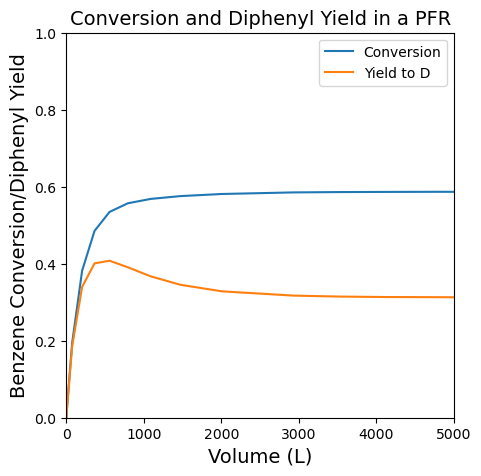

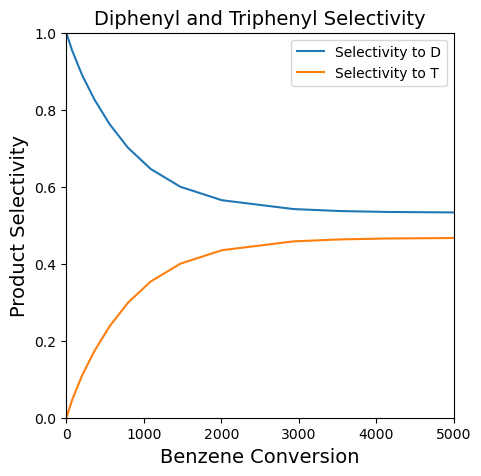

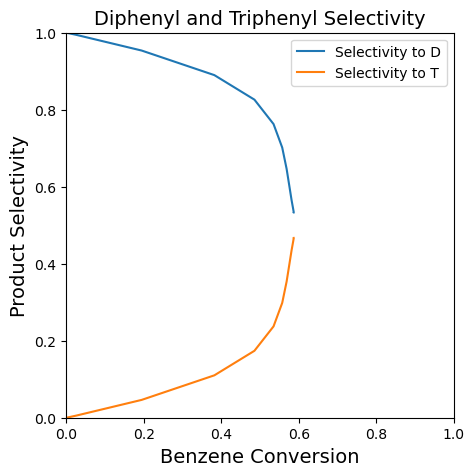

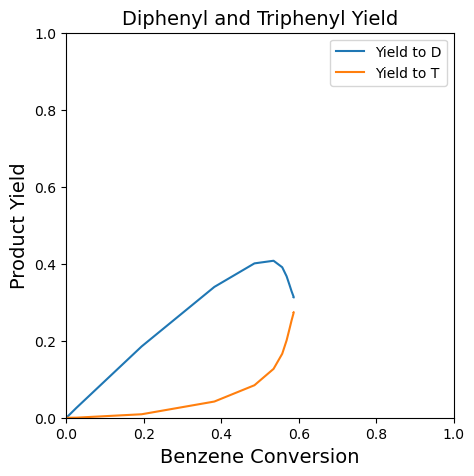

In [15]:
#########################################################################################
# See solution to example problem 1; Flowrates are defined in cells there               #
#########################################################################################

#########################################################################################
# Calculate diphenyl/triphenyl yield                                                    #
#########################################################################################

YDB     = FDout*2/FBf
YTB     = FTout*3/FBf

#########################################################################################
# Calculate diphenyl/triphenyl selectivity                                              #
#########################################################################################
SDB     = FDout*2/(FBf - FBout)
STB     = FTout*3/(FBf - FBout)

#########################################################################################
# Plot yield, selectivity, conversion against various x axes                            #
#########################################################################################

#########################
# Conversion vs. volume #
#########################

plt.figure(figsize = (5, 5))
plt.title('Conversion and Diphenyl Yield in a PFR', fontsize = 14)
plt.plot(Vout, XBout, label = 'Conversion')
plt.plot(Vout, YDB, label = 'Yield to D')
plt.xlim(0, max(vspan))
plt.ylim(0, 1)
plt.xlabel('Volume (L)', fontsize = 14)
plt.ylabel('Benzene Conversion/Diphenyl Yield', fontsize = 14)
plt.legend()
plt.show()

#############################
# Selectivity vs volume     #
#############################

plt.figure(figsize = (5, 5))
plt.title('Diphenyl and Triphenyl Selectivity', fontsize = 14)
plt.plot(Vout, SDB, label = 'Selectivity to D')
plt.plot(Vout, STB, label = 'Selectivity to T')
plt.xlim(0, max(vspan))
plt.ylim(0, 1)
plt.xlabel('Benzene Conversion', fontsize = 14)
plt.ylabel('Product Selectivity', fontsize = 14)
plt.legend()
plt.show()

#############################
# Selectivity vs conversion #
#############################

plt.figure(figsize = (5, 5))
plt.title('Diphenyl and Triphenyl Selectivity', fontsize = 14)
plt.plot(XBout, SDB, label = 'Selectivity to D')
plt.plot(XBout, STB, label = 'Selectivity to T')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Benzene Conversion', fontsize = 14)
plt.ylabel('Product Selectivity', fontsize = 14)
plt.legend()
plt.show()

#########################
# Yield vs. conversion  #
#########################

plt.figure(figsize = (5, 5))
plt.title('Diphenyl and Triphenyl Yield', fontsize = 14)
plt.plot(XBout, YDB, label = 'Yield to D')
plt.plot(XBout, YTB, label = 'Yield to T')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Benzene Conversion', fontsize = 14)
plt.ylabel('Product Yield', fontsize = 14)
plt.legend()
plt.show()

#### Finding the value and location of the maximum diphenyl yield

First, we'll use `max()` and `np.argmax()` to get a crude approximation of the maximum, 

```{caution}
This is a relatively crude optimization because we are finding the maximum mole fraction of diphenyl that ***the solver stepped to*** when solving the ODE system.  The true maximum of the continuous function will almost certaintly be slightly different from this. The two will agree as we continue to increase the precision and take smaller and smaller steps during the ODE solution process.
```

0.40772971719188217
The maximum diphenyl yield is approximately 0.408. 

8
0.40772971719188217
The maximum diphenyl yield is 0.408, which we obtain at a PFR volume of 557L. 



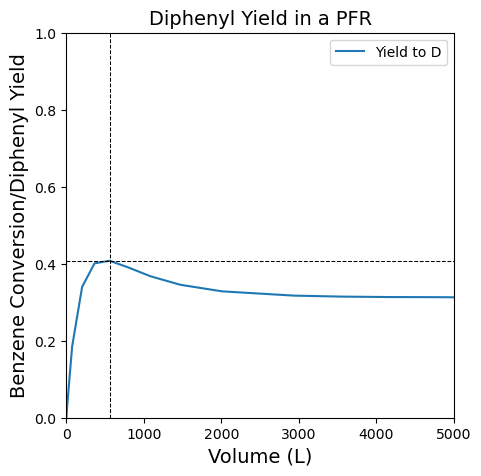

In [16]:
######################################################################################
# use max() to find the largest element in an array                                  #
######################################################################################

YDBmax1 = max(YDB)
print(YDBmax1)
print(f'The maximum diphenyl yield is approximately {YDBmax1:0.3f}. \n')

######################################################################################
# use numpy.argmax() to find the index of the largest element in an array            # 
######################################################################################

indexmax = np.argmax(YDB)
print(indexmax)
print(YDB[indexmax])
YDBmax2   = YDB[indexmax]
Vmax2    = Vout[indexmax]
print(f'The maximum diphenyl yield is {YDBmax2:0.3f}, which we obtain at a PFR volume of {Vmax2:0.0f}L. \n')

######################################################################################
# Visualize diphenyl yield vs. volume; confirm that maximum is approximately correct #
######################################################################################

plt.figure(figsize = (5, 5))
plt.title('Diphenyl Yield in a PFR', fontsize = 14)
plt.plot(Vout, YDB, label = 'Yield to D')
plt.hlines(YDBmax2, 0, max(vspan), linestyle = 'dashed', color = 'black', linewidth = 0.75)
plt.vlines(Vmax2, 0, 1, linestyle = 'dashed', color = 'black', linewidth = 0.75)
plt.xlim(0, max(vspan))
plt.ylim(0, 1)
plt.xlabel('Volume (L)', fontsize = 14)
plt.ylabel('Benzene Conversion/Diphenyl Yield', fontsize = 14)
plt.legend()
plt.show()

#### Optimize using an interpolating polynomial YDB(V)

Next, we'll refine that estimate bit by creating an interpolating polynomial that returns Volume as a function of diphenyl yield.  We'll use that with `opt.minimize_scalar()` to find the location of the optimum.  This is the same strategy we introduced for optimization of a scalar function in [Notebook 28](https://jqbond.github.io/CEN587/Notebooks/587-N28.html).

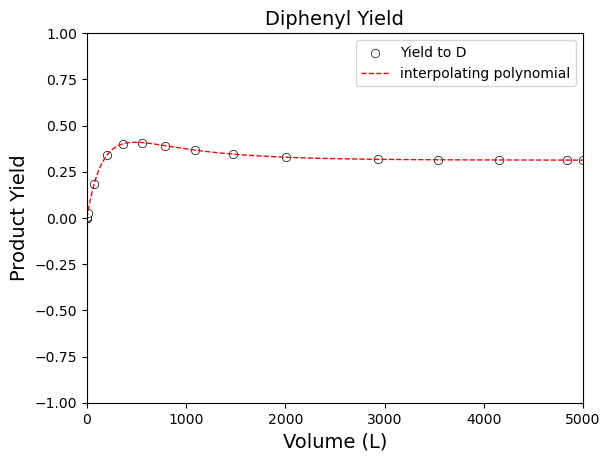

In [17]:
##############################################################################
# Creating interpolating polynomial approximation for YDV(V)                 #
##############################################################################

YvVol = interp1d(Vout, YDB, kind = 'cubic')

##############################################################################
# Overlay plot of interpolating polynomial with discrete YDV from ODE solver #
##############################################################################

vset = np.linspace(0, 5000, 200)
plt.title('Diphenyl Yield', fontsize = 14)
plt.scatter(Vout, YDB, color = 'white', edgecolor = 'black', linewidths = 0.5, label = 'Yield to D')
plt.plot(vset, YvVol(vset), color = 'red', linewidth = 1, linestyle = 'dashed', label = 'interpolating polynomial')
plt.xlim(0, 5000)
plt.ylim(-1, 1)
plt.xlabel('Volume (L)', fontsize = 14)
plt.ylabel('Product Yield', fontsize = 14)
plt.legend()
plt.show()

##### Optimizing the Yield

Now that we have a continuous function that approximates $Y_{D/B}(V)$, we can transform it into an objective function for minimization and use `opt.minimize_scalar()' to find the location of the minimum.  We would like to ***maximize*** yield, which is the same thing as ***minimizing*** negative yield; hence, we can define an adequate objective function as:

$$\mathrm{obj}(V) = -Y_{D/B}$$

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: -0.40944730167712584
       x: 486.07977133672665
     nit: 10
    nfev: 17
The maximum yield is 0.409 at a PFR volume of 486L


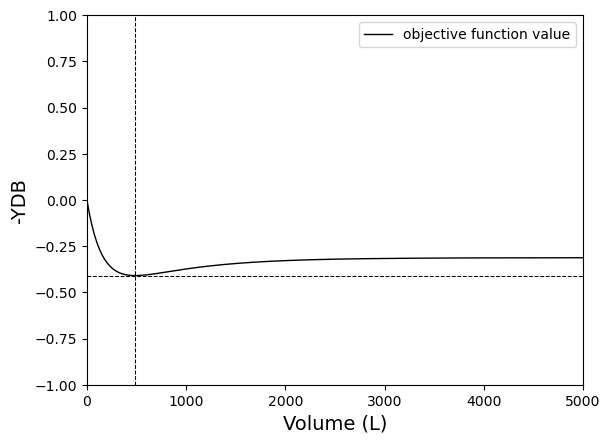

In [18]:
############################################################
# Define objective function to minimize                    #
############################################################

obj = lambda V: -1*YvVol(V)

############################################################
# Find the value of V that minimizes obj(V)                #
############################################################

opt_ans = opt.minimize_scalar(obj)

############################################################
# Display answers                                          #
############################################################

print(opt_ans)
print(f'The maximum yield is {-1*opt_ans.fun:3.3f} at a PFR volume of {opt_ans.x:3.0f}L')


############################################################
# Graph the objective function vs. volume; confirm minimum #
############################################################

plt.plot(vset, obj(vset), color = 'black', linewidth = 1, linestyle = 'solid', label = 'objective function value')
plt.hlines(opt_ans.fun, 0, max(vspan), linestyle = 'dashed', color = 'black', linewidth = 0.75)
plt.vlines(opt_ans.x, -1, 1, linestyle = 'dashed', color = 'black', linewidth = 0.75)
plt.xlim(0, 5000)
plt.ylim(-1, 1)
plt.xlabel('Volume (L)', fontsize = 14)
plt.ylabel('-YDB', fontsize = 14)
plt.legend()
plt.show()